<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>MetPy Case Study</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

A tutorial on building a case study map for Dynamic Meteorology courses with use of Unidata tools, specifically MetPy and Siphon. In this tutorial we will cover accessing, calculating, and plotting model output.

Let's investigate The Storm of the Century, although it would easy to change which case you wanted (please feel free to do so).

Reanalysis Output: NARR 00 UTC 13 March 1993

Data from Reanalysis on pressure surfaces:
* Geopotential Heights
* Temperature
* u-wind component
* v-wind component

Calculations:
* Vertical Vorticity
* Advection of Temperature and Vorticity
* Horizontal Divergence
* Wind Speed

Dependencies:
- numpy <=1.11
- metpy 0.6.1+ (latest repo)
- caropty
- scipy
- matplotlib
- siphon
- datetime
- netCDF4

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from netCDF4 import Dataset, num2date
import numpy as np
from scipy.ndimage import gaussian_filter
from siphon.ncss import NCSS
from siphon.simplewebservice.wyoming import WyomingUpperAir
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import StationPlot
from metpy.units import units

In [2]:
from pyproj import Geod
# Helper function to calculate distance between lat/lon points
# to be used in differencing calculations
def calc_dx_dy(longitude, latitude, **kwargs):
    r"""Calculate the distance between grid points that are in a latitude/longitude format.
    Calculate the distance between grid points when the grid spacing is defined by
    delta lat/lon rather than delta x/y
    Parameters
    ----------
    longitude : array_like
        array of longitudes defining the grid
    latitude : array_like
        array of latitudes defining the grid
    kwargs
        Other keyword arguments to pass to :class:`~pyproj.Geod`
    Returns
    -------
     dx, dy: 2D arrays of distances between grid points in the x and y direction
    Notes
    -----
    Accepts, 1D or 2D arrays for latitude and longitude
    Assumes [Y, X] for 2D arrays
    """
    # Inputs must be the same number of dimensions
    if latitude.ndim != longitude.ndim:
        raise ValueError('Latitude and longitude must have the same number of dimensions.')

    # If we were given 1D arrays, make a mesh grid
    if latitude.ndim == 1:
        longitude, latitude = np.meshgrid(longitude, latitude)

    geod_args = {'ellps': 'sphere'}
    geod_args.update(**kwargs)
    g = Geod(**geod_args)

    dy = np.zeros(latitude.shape)
    dx = np.zeros(longitude.shape)
    
    _, _, dy[:-1,:] = g.inv(longitude[:-1, :], latitude[:-1, :], longitude[1:, :], latitude[1:, :])
    _, _, dx[:,:-1] = g.inv(longitude[:, :-1], latitude[:, :-1], longitude[:, 1:], latitude[:, 1:])

    dy[-1,:] = np.nan
    dx[:,-1] = np.nan
    
    return dx * units.meter, dy * units.meter

## Case Study Data

There are a number of different sites that you can utilize to access past model output analyses and even forecasts. The most robust collection is housed at the National Center for Environmental Information (NCEI, formerly NCDC) on a THREDDS server. The general website to begin your search is

https://www.ncdc.noaa.gov/data-access

this link contains links to many different data sources (some of which we will come back to later in this tutorial). But for now, lets investigate what model output is avaiable

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets

The gridded model output that are available

**Reanalysis**
 * Climate Forecast System Reanalysis (CFSR)
   * CFSR provides a global reanalysis (a best estimate of the observed state of the atmosphere) of past weather from January 1979 through March 2011 at a horizontal resolution of 0.5°.
 * North American Regional Reanalysis (NARR)
   * NARR is a regional reanalysis of North America containing temperatures, winds, moisture, soil data, and dozens of other parameters at 32km horizontal resolution.
 * Reanalysis-1 / Reanalysis-2 (R1/R2)
   * Reanalysis-1 / Reanalysis-2 are two global reanalyses of atmospheric data spanning 1948/1979 to present at a 2.5° horizontal resolution.

**Numerical Weather Prediction**
 * Climate Forecast System (CFS) 
   * CFS provides a global reanalysis, a global reforecast of past weather, and an operational, seasonal forecast of weather out to nine months.
 * Global Data Assimilation System (GDAS)
   * GDAS is the set of assimilation data, both input and output, in various formats for the Global Forecast System model.
 * Global Ensemble Forecast System (GEFS)
   * GEFS is a global-coverage weather forecast model made up of 21 separate forecasts, or ensemble members, used to quantify the amount of uncertainty in a forecast. GEFS produces output four times a day with weather forecasts going out to 16 days.
 * Global Forecast System (GFS)
   * The GFS model is a coupled weather forecast model, composed of four separate models which work together to provide an accurate picture of weather conditions. GFS covers the entire globe down to a horizontal resolution of 28km.
 * North American Mesoscale (NAM)
   * NAM is a regional weather forecast model covering North America down to a horizontal resolution of 12km. Dozens of weather parameters are available from the NAM grids, from temperature and precipitation to lightning and turbulent kinetic energy.
 * Rapid Refresh (RAP)
   * RAP is a regional weather forecast model of North America, with separate sub-grids (with different horizontal resolutions) within the overall North America domain. RAP produces forecasts every hour with forecast lengths going out 18 hours.  RAP replaced the Rapid Update Cycle (RUC) model on May 1, 2012.
 * Navy Operational Global Atmospheric Prediction System (NOGAPS)
   * NOGAPS analysis data are available in six-hourly increments on regularly spaced latitude-longitude grids at 1-degree and one-half-degree resolutions. Vertical resolution varies from 18 to 28 pressure levels, 34 sea level depths, the surface, and other various levels.

**Ocean Models**
 * Hybrid Coordinate Ocean Model (HYCOM), Global
   * The Navy implementation of HYCOM is the successor to Global NCOM. This site hosts regions covering U.S. coastal waters as well as a global surface model.
 * Navy Coastal Ocean Model (NCOM), Global
   * Global NCOM was run by the Naval Oceanographic Office (NAVOCEANO) as the Navy’s operational global ocean-prediction system prior to its replacement by the Global HYCOM system in 2013. This site hosts regions covering U.S., European, West Pacific, and Australian coastal waters as well as a global surface model.
 * Navy Coastal Ocean Model (NCOM), Regional
   * The Regional NCOM is a high-resolution version of NCOM for specific areas. NCEI serves the Americas Seas, U.S. East, and Alaska regions of NCOM.
 * Naval Research Laboratory Adaptive Ecosystem Climatology (AEC)
   * The Naval Research Laboratory AEC combines an ocean model with Earth observations to provide a synoptic view of the typical (climatic) state of the ocean for every day of the year. This dataset covers the Gulf of Mexico and nearby areas.
 * National Centers for Environmental Prediction (NCEP) Real Time Ocean Forecast System (RTOFS)–Atlantic
   * RTOFS–Atlantic is a data-assimilating nowcast-forecast system operated by NCEP. This dataset covers the Gulf of Mexico and most of the northern and central Atlantic.

**Climate Prediction**
 * CM2 Global Coupled Climate Models (CM2.X)
   * CM2.X consists of two climate models to model the changes in climate over the past century and into the 21st century.
 * Coupled Model Intercomparison Project Phase 5 (CMIP5) (link is external)
   * The U.N. Intergovernmental Panel on Climate Change (IPCC) coordinates global analysis of climate models under the Climate Model Intercomparison Project (CMIP). CMIP5 is in its fifth iteration. Data are available through the Program for Climate Model Diagnosis and Intercomparison (PCMDI) website.
   
**Derived / Other Model Data**
 * Service Records Retention System (SRRS)
   * SRRS is a store of weather observations, summaries, forecasts, warnings, and advisories generated by the National Weather Service for public use.
 * NOMADS Ensemble Probability Tool
   * The NOMADS Ensemble Probability Tool allows a user to query the Global Ensemble Forecast System (GEFS) to determine the probability that a set of forecast conditions will occur at a given location using all of the 21 separate GEFS ensemble members.
 * National Digital Forecast Database (NDFD)
   * NDFD are gridded forecasts created from weather data collected by National Weather Service field offices and processed through the National Centers for Environmental Prediction. NDFD data are available by WMO header or by date range.
 * National Digital Guidance Database (NDGD)
   * NDGD consists of forecasts, observations, model probabilities, climatological normals, and other digital data that complement the National Digital Forecast Database.

## NARR Output
Lets investigate what specific NARR output is available to work with from NCEI.

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr

We specifically want to look for data that has "TDS" data access, since that is short for a THREDDS server data access point. There are a total of four different GFS datasets that we could potentially use.


**Choosing our data source**
Let's go ahead and use the NARR Analysis data to investigate the past case we identified (The Storm of the Century).

https://www.ncei.noaa.gov/thredds/catalog/narr-a-files/199303/19930313/catalog.html?dataset=narr-a-files/199303/19930313/narr-a_221_19930313_0000_000.grb

And we will use a python package called Siphon to read this data through the NetCDFSubset (NetCDFServer) link.

https://www.ncei.noaa.gov/thredds/ncss/grid/narr-a-files/199303/19930313/narr-a_221_19930313_0000_000.grb/dataset.html

In [3]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 0

dt = datetime(year ,month, day, hour)

In [4]:
# Read NARR Data from THREDDS server
ncss = NCSS('http://nomads.ncdc.noaa.gov/thredds/ncss/grid/narr-a/' + dt.strftime('%Y%m') +
            '/' + dt.strftime('%Y%m%d') + '/narr-a_221_' + dt.strftime('%Y%m%d') + '_' +
            dt.strftime('%H') + '00_000.grb')
query = ncss.query().lonlat_box(north=60, south=18, east=300, west=225)
query.all_times().variables('Geopotential_height', 'u_wind', 'v_wind',
                            'Temperature').add_lonlat().accept('netcdf4')
data = ncss.get_data(query)

In [5]:
# Back up in case of bad internet connection.
# Uncomment the following line to read local netCDF file of NARR data
# data = Dataset('../../data/NARR_19930313_0000.nc','r')

## Pulling Data for Calculation/Plotting

The object that we get from Siphon is netCDF-like, so we can pull data using familiar calls for all of the variables that are desired for calculations and plotting purposes.

**NOTE:**
Due to the curvilinear nature of the NARR grid, there is a need to smooth the data that we import for calculation and plotting purposes. For more information about why, please see the following link: http://www.atmos.albany.edu/facstaff/rmctc/narr/

Additionally, we want to attach units to our values for use in MetPy calculations later and it will also allow for easy conversion to other units.

In [6]:
# %load solutions/parse_data.py

## Finding Pressure Level Data
A robust way to parse the data for a certain pressure level is to find the index value using the `np.where` function. Since the NARR pressure data ('levels') is in hPa, then we'll want to search that array for our pressure levels 850, 500, and 300 hPa.

In [7]:
# %load solutions/pick_levels.py

## Using MetPy to Calculate Atmospheric Dynamic Quantities

MetPy has a large and growing list of functions to calculate many different atmospheric quantities. Here we want to use some classic functions to calculate wind speed, advection, planetary vorticity, relative vorticity, and divergence.

* Wind Speed: `mpcalc.get_wind_speed()`
* Advection: `mpcalc.advection()`
* Planetary Vorticity: `mpcalc.coriolis_parameter()`
* Relative Vorticity: `mpcalc.v_vorticity()`
* Divergence: `mpcalc.h_divergence()`

Note: For the above, MetPy Calculation module is imported in the following manner `import metpy.calc as mpcalc`.

### Temperature Advection

A classic QG forcing term is 850-hPa temperature advection. MetPy has a function for advection

https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.advection.html#metpy.calc.advection

`advection(scalar quantity, [advecting vector components], (grid spacing components))`

So for temperature advection our scalar quantity would be the tempertaure, the advecting vector components would be our u and v components of the wind, and the grid spacing would be our dx and dy we computed in an earier cell.

In [8]:
# %load solutions/temp_adv.py

### Vorticity Calculations

There are a couple of different vorticities that we are interested in for various calculations, planetary vorticity, relative vorticity, and absolute vorticity. Currently MetPy has two of the three as functions within the calc module.

**Planetary Vorticity (Coriolis Parameter)**

`coriolis_parameter(latitude in radians)`

https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.coriolis_parameter.html#metpy.calc.coriolis_parameter

Note: You must can convert your array of latitudes to radians...NumPy give a great function `np.deg2rad()` or have units attached to your latitudes in orde for MetPy to convert them for you! Always check your output to make sure that your code is producing what you think it is producing.

**Relative Vorticity**

When atmospheric scientists talk about relative vorticity, we are really refering to the relative vorticity that is occuring about the vertical axis (the k-hat component). So in MetPy the function is

`v_vorticity(uwind, vwind, dx, dy)`

** Absolute Vorticity**

Currently there is no specific function for Absolute Vorticity, but this is easy for us to calculate from the previous two calculations because we just need to add them together!

`ABS Vort = Rel. Vort + Coriolis Parameter`

Here having units are great, becase we won't be able to add things together that don't have the same units! Its a nice safety check just in case you entered something wrong in another part of the calculation, you'll get a units error.

In [9]:
# %load solutions/vorticity.py

### Vorticity Advection

We use the same MetPy function for temperature advection for our vorticity advection, we just have to change the scalar quantity (what is being advected) and have appropriate vector quantities for the level our scalar is from. So for vorticity advections well want our wind components from 500 hPa.

In [10]:
# Vorticity Advection
f_adv = mpcalc.advection(f, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

relvort_adv = mpcalc.advection(vor_500, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

absvort_adv = mpcalc.advection(avor_500, [uwnd_500, vwnd_500], (dx, dy), dim_order='yx')

### Divergence and Stretching Vorticity

If we want to analyze another component of the vorticity tendency equation other than advection, we might want to assess the stretching forticity term.

`-(Abs. Vort.)*(Divergence)`

We already have absolute vorticity calculated, so now we need to calculate the divergence of the level, which MetPy has a function

`h_convergence(uwnd, vwnd, dx, dy)`

This function computes the horizontal divergence (and will be called `h_divergence` in the near future.

In [11]:
# Stretching Vorticity
div_500 = mpcalc.h_convergence(uwnd_500, vwnd_500, dx, dy, dim_order='yx')

stretch_vort = -1 * avor_500 * div_500

### Wind Speed, Geostrophic and Ageostrophic Wind

**Wind Speed**

Calculating wind speed is not a difficult calculation, but MetPy offers a function to calculate it easily keeping units so that it is easy to convert units for plotting purposes.

`get_wind_speed(uwnd, vwnd)`

https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.get_wind_speed.html#metpy.calc.get_wind_speed

**Geostrophic Wind**

The geostrophic wind can be computed from a given height gradient and coriolis parameter

`geostrophic_wind(heights, coriolis parameter, dx, dy)`

https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.geostrophic_wind.html#metpy.calc.geostrophic_wind

This function will return the two geostrophic wind components in a tuple. On the left hand side you'll be able to put two variables to save them off separately, if desired.

**Ageostrophic Wind**

Currently, there is not a function in MetPy for calculating the ageostrophic wind, however, it is again a simple arithmatic operation to get it from the total wind (which comes from our data input) and out calculated geostrophic wind from above.

`Ageo Wind = Total Wind - Geo Wind`


In [12]:
# Divergence 300 hPa, Ageostrophic Wind
wspd_300 = mpcalc.get_wind_speed(uwnd_300, vwnd_300).to('kts')

div_300 = mpcalc.h_convergence(uwnd_300, vwnd_300, dx, dy, dim_order='yx')
ugeo_300, vgeo_300 = mpcalc.geostrophic_wind(hght_300, f, dx, dy, dim_order='yx')

uageo_300 = uwnd_300 - ugeo_300
vageo_300 = vwnd_300 - vgeo_300

## Maps and Projections

In [13]:
# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100., central_latitude=40.,
                                 standard_parallels=[30, 60])

states_provinces = cfeat.NaturalEarthFeature(category='cultural',
                                             name='admin_1_states_provinces_lakes',
                                             scale='50m',
                                             facecolor='none')

In [14]:
def create_map_background():
    fig=plt.figure(figsize=(14, 12))
    ax=plt.subplot(111, projection=plotproj)
    ax.set_extent([-125, -73, 25, 50],ccrs.PlateCarree())
    ax.coastlines('50m', edgecolor='black', linewidth=0.75)
    ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)
    return fig, ax

## 850-hPa Temperature Advection

* Add one contour (Temperature in Celsius with a dotted linestyle
* Add one colorfill (Temperature Advection in C/hr)

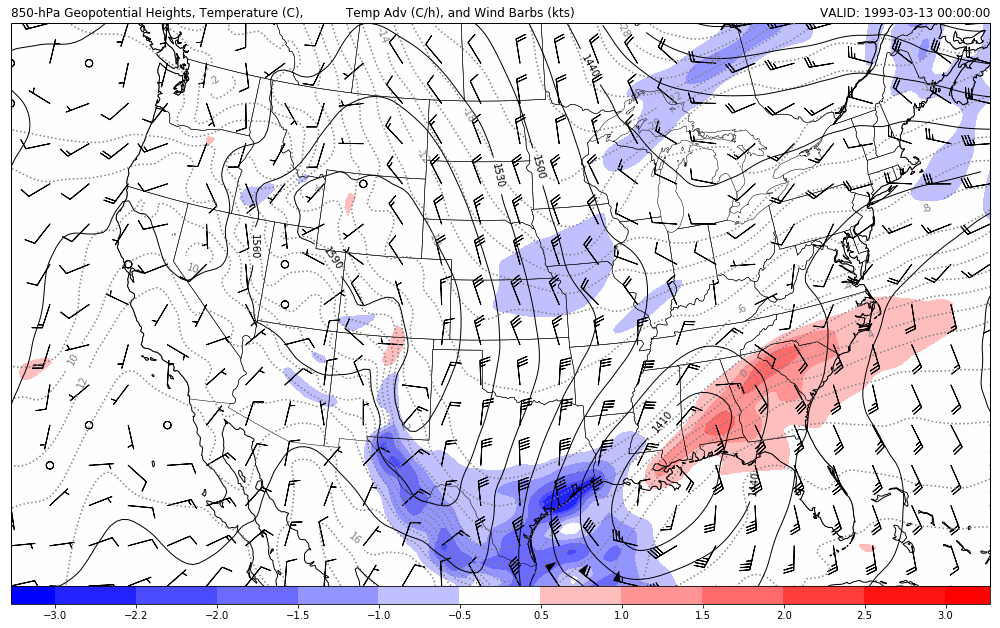

In [16]:
# %load solutions/map_850_Tadv.py

## 500-hPa Absolute Vorticity
* Add code for plotting vorticity as a colorfill with given lvels and colors

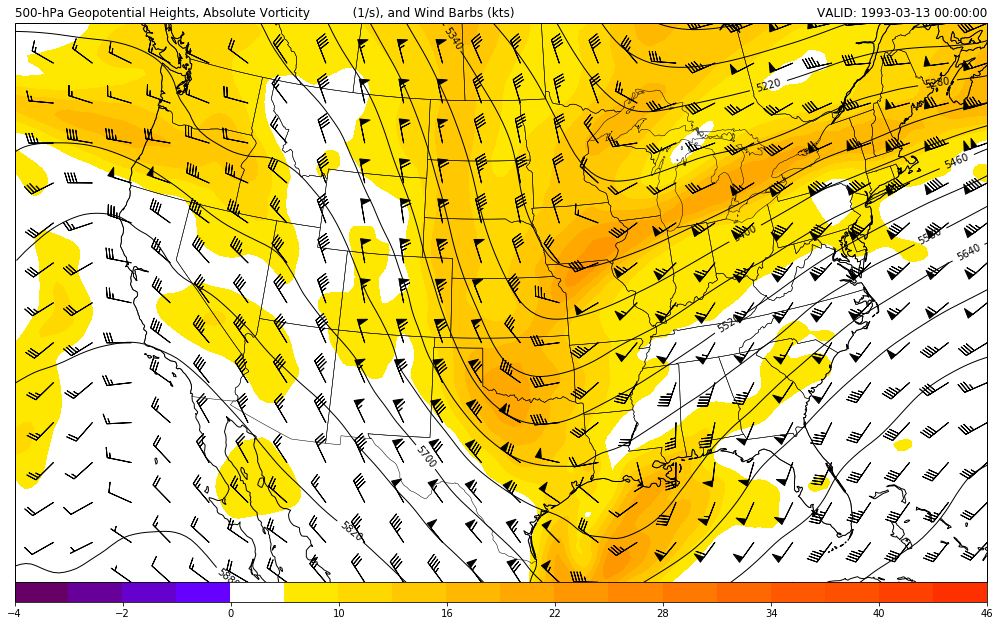

In [17]:
# %load solutions/map_500_Vort.py

## 300-hPa Wind Speed, Divergence, and Ageostrophic Wind

* Add code to plot 300-hPa Ageostrophic Wind vectors using matplotlib's quiver function

/Users/jleeman/miniconda3/envs/unidata-workshop/lib/python3.6/site-packages/cartopy/vector_transform.py:131: RuntimeWarning: invalid value encountered in less
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)
/Users/jleeman/miniconda3/envs/unidata-workshop/lib/python3.6/site-packages/cartopy/vector_transform.py:131: RuntimeWarning: invalid value encountered in greater
  u, v = target_proj.transform_vectors(src_crs, x, y, u, v)


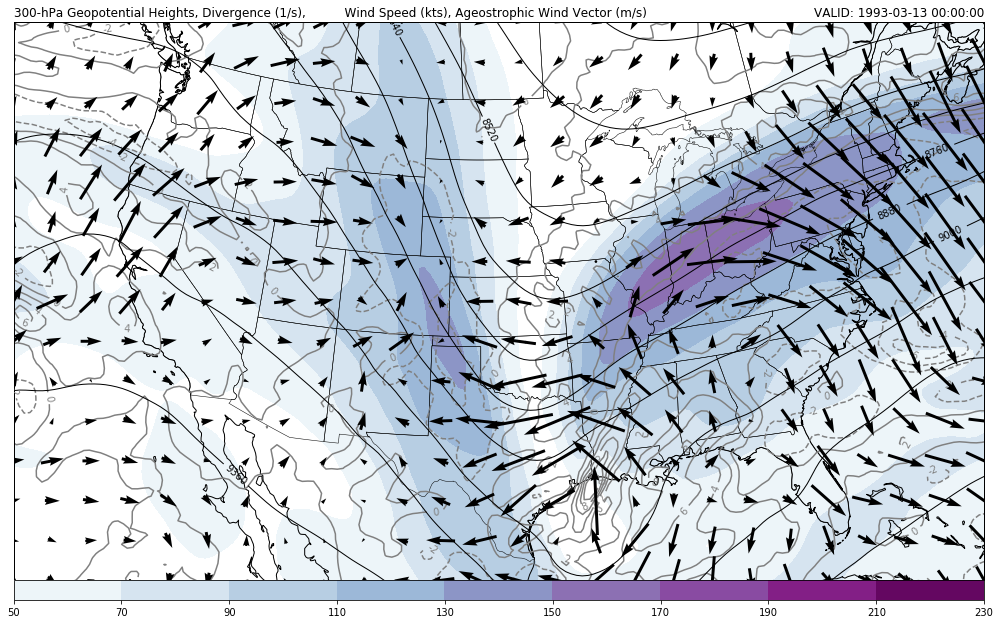

In [18]:
# %load solutions/map_300_div_ageo.py

## Vorticity Tendency Terms

Here is an example of a four-panel plot for a couple of terms in the Vorticity Tendency equation

Upper-left Panel: Planetary Vorticity Advection

Upper-right Panel: Relative Vorticity Advection

Lower-left Panel: Absolute Vorticity Advection

Lower-right Panel: Stretching Vorticity

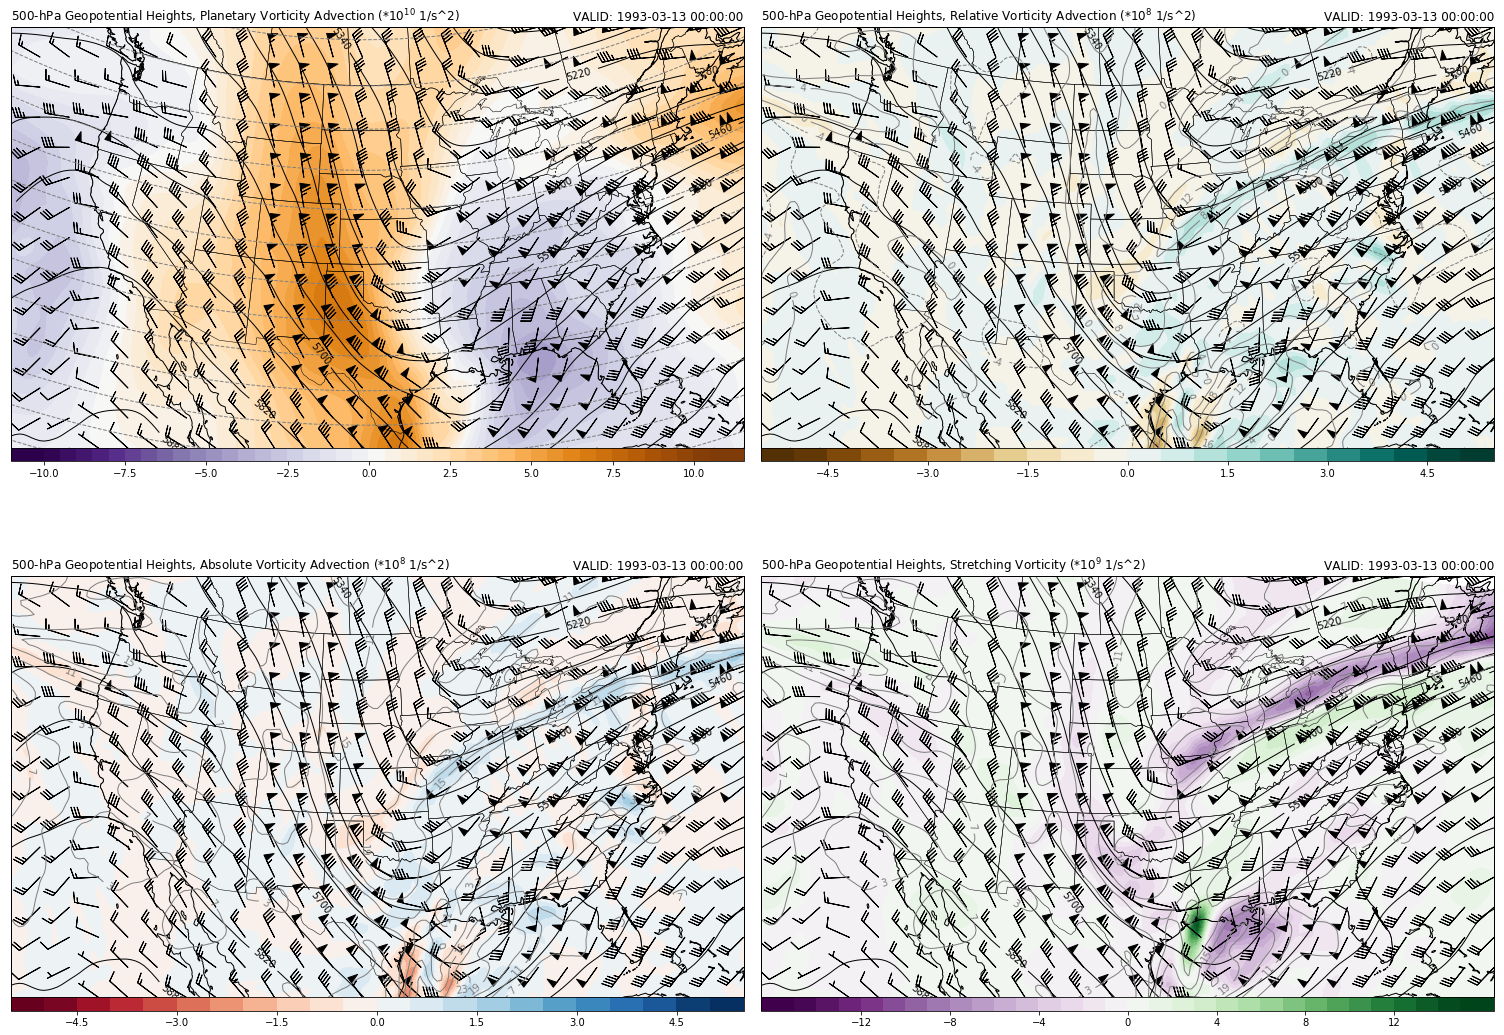

In [19]:
fig=plt.figure(1,figsize=(21.,16.))

# Upper-Left Panel
ax=plt.subplot(221,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,f*10**4,np.arange(0,3,.05),colors='grey',
                linewidths=1.0,linestyles='dashed',transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%.2f', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,f_adv*10**10,np.arange(-10,11,0.5),
                 cmap='PuOr_r',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Planetary Vorticity Advection ($*10^{10}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Upper-Right Panel
ax=plt.subplot(222,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,vor_500*10**5,np.arange(-40,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,relvort_adv*10**8,np.arange(-5,5.5,0.5),
                 cmap='BrBG',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Relative Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Lower-Left Panel
ax=plt.subplot(223,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,avor_500*10**5,np.arange(-5,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,absvort_adv*10**8,np.arange(-5,5.5,0.5),
                 cmap='RdBu',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Absolute Vorticity Advection ($*10^{8}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Lower-Right Panel
ax=plt.subplot(224,projection=plotproj)
ax.set_extent([-125.,-73,25.,50.],ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lon,lat,hght_500,clev500,colors='k',
                linewidths=1.0,linestyles='solid',transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i', rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lon,lat,gaussian_filter(avor_500*10**5,sigma=1.0),np.arange(-5,41,4),colors='grey',
                linewidths=1.0,transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d', rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lon,lat,gaussian_filter(stretch_vort*10**9,sigma=1.0),np.arange(-15,16,1),
                 cmap='PRGn',extend='both',transform=dataproj)
plt.colorbar(cf, orientation='horizontal',pad=0.0,aspect=50,extendrect=True)

# Vector
ax.barbs(lon,lat,uwnd_500.to('kts').m,vwnd_500.to('kts').m,regrid_shape=15,transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Stretching Vorticity ($*10^{9}$ 1/s^2)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

## Plotting Data for Hand Calculation

Calculating dynamic quantities with a computer is great and can allow for many different educational opportunities, but there are times when we want students to calculate those quantities by hand. So can we plot values of geopotential height, u-component of the wind, and v-component of the wind on a map? Yes! And its not too hard to do.

Since we are using NARR data, we'll plot every third point to get a roughly 1 degree by 1 degree separation of grid points and thus an average grid spacing of 111 km (not exact, but close enough for back of the envelope calculations).

To do our plotting we'll be using the functionality of MetPy to plot station plot data, but we'll use our gridded data to plot around our points. To do this we'll have to make or 2D data into 1D (which is made easy by the `ravel()` method associated with our data objects).

First we'll want to set some bounds (so that we only plot what we want) and create a mask to make plotting easier.

Second we'll set up our figure with a projection and then set up our "stations" at the grid points we desire using the MetPy class `StationPlot`

https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html#metpy.plots.StationPlot

Third we'll plot our points using matplotlibs `scatter()` function and use our stationplot object to plot data around our "stations"

In [20]:
# Set lat/lon bounds for region to plot data
LLlon = -104
LLlat = 33
URlon = -94
URlat = 38

# Set up mask so that you only plot what you want
mask_lon = ((lon[::3,::3].ravel() > LLlon + 0.05) & (lon[::3,::3].ravel() < URlon + 0.01))
mask_lat = ((lat[::3,::3].ravel() < URlat - 0.01) & (lat[::3,::3].ravel() > LLlat - 0.01))
mask = mask_lon & mask_lat

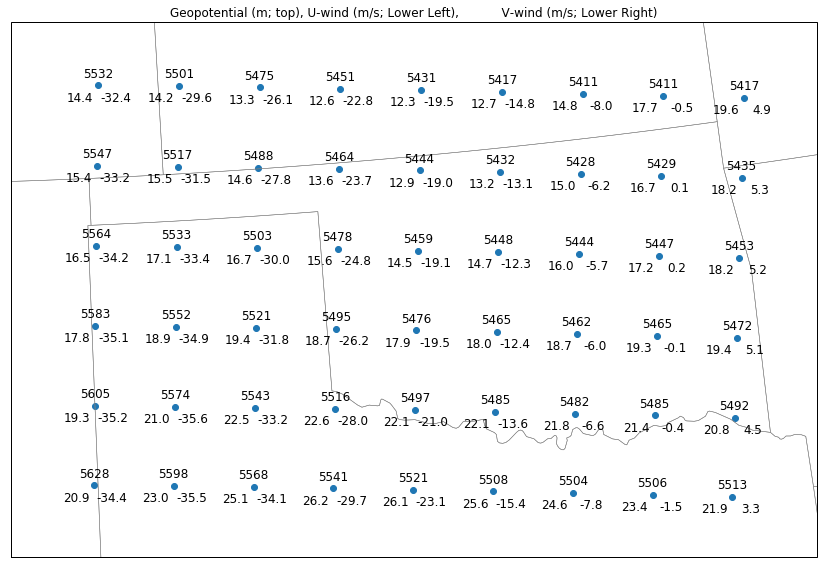

In [22]:
# %load solutions/map_data_500.py
# Set up plot basics and use StationPlot class from MetPy to help with plotting